## Gesture Recognition Training for Summit AI Demo

* Read training data from S3
* Combine multiple json files into single time-series.
* Featurize time-series data
* Train and test Random Forest model
* Train and test Feed-Forward model
* Save model for use by TF-Serve

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import s3fs
import pandas as pd
import numpy as np
import scipy.stats
import time
import multiprocessing as mp
from natsort import natsorted
import json
import matplotlib.pylab as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf
from tensorflow import keras

In [4]:
def collect_featured_data_from_s3(path, fs, label):
    top_dir = fs.ls(path)
    data = []
    
    for files in top_dir:
        # df = None
        bottom_dir = natsorted(fs.ls(files))
        df = combine_multiple_json(bottom_dir)
        df = turn_jsons_into_joint_dataframe(df)
        df = get_accleration_timeseries(df)
        params = [df, label, np.arange(0,100,10)]
        example = featurize(params)
        data.append(example)
        
    return data # a list that has a featurized vector (as a dictioanry) for each folder in top_dir (each capture session)


def mp_collect_featured_data_from_s3(path, fs, label):
    top_dir = fs.ls(path)
    data = []
    data_params = []
    
    for files in top_dir:
        # df = None
        bottom_dir = natsorted(fs.ls(files))
        df = combine_multiple_json(bottom_dir)
        df = turn_jsons_into_joint_dataframe(df)
        df = get_accleration_timeseries(df)
        params = (df, label, np.arange(0,100,10))
        data_params.append(params)
        
    #then = time.time()
    pool = mp.Pool(processes=8)
    data = pool.map(featurize,data_params)
    #print((time.time()-then)/60, "minutes")
        
    return data # a list that has a featurized vector (as a dictioanry) for each folder in top_dir (each capture session)


In [5]:
def combine_multiple_json(bottom_dir):
    
    df = pd.DataFrame([])
    obj = []
    
    for partial_json  in bottom_dir:
        x = fs.open(partial_json)
        data = x.read()
        x.close()
        temp = json.loads(data)
        obj.append(temp['motion'])
        
    return obj # list of motion data in multiple json files representing one capture session

def turn_jsons_into_joint_dataframe(a_list):
    df = pd.DataFrame()
    for item in a_list:
        temp = pd.io.json.json_normalize(item)
        df = df.append(temp, ignore_index=True, sort=False)
        df = df.iloc[:,0:3]
  
    return df # 3xn dataframe of acceleration data  

def get_accleration_timeseries(timeseries):
    
    timeseries = timeseries.apply((lambda x: x**2))
    timeseries = timeseries.sum(axis=1)
    timeseries = timeseries.apply(np.sqrt)
    
    return timeseries # 1xn Series 

def featurize(params):
    ts = params[0]
    label = params[1]
    bins = params[2]
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {'mean_over_median': 0, #dimensionless            
                    'std_over_median': 0, #dimensionless            
                    'length': length,
                    'kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {'mean_over_median': mean/median, #dimensionless            
            'std_over_median': std/median, #dimensionless            
            'length': length,
            'kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    features['label'] = label
    
    
    return features
    

### Get Data

Pull gesture data from S3 and convert it into a featurized representation. 

In [ ]:
then = time.time()

path_to_data = 'cchase-rh-demo-4/mock-server-data/motions/2019-02-27'
fs = s3fs.S3FileSystem()
gesture_O = mp_collect_featured_data_from_s3(path_to_data,fs, 'O')
  
print((time.time()-then)/60, "minutes")

In [ ]:
then = time.time()

path_to_data = 'cchase-rh-demo-4/mock-server-data/motions/2019-02-26'
fs = s3fs.S3FileSystem()
gesture_X = mp_collect_featured_data_from_s3(path_to_data,fs, 'X')
  
print((time.time()-then)/60, "minutes")

In [ ]:
df  ==  pd.DataFrame(gesture_Ogesture[:185] + gesture_X)

Or load from local csv files

In [7]:
_train_df = pd.read_csv('data/accelerometer/xo/train.csv')
_test_df = pd.read_csv('data/accelerometer/xo/test.csv')

df = pd.concat((_test_df, _train_df))

del _train_df
del _test_df

### Model Training

Split the data for training and testing with both a Random Forest model and a Feed-Forward network. 

In [8]:
df = df.dropna()

In [9]:
train_df, test_df = train_test_split(df, train_size=0.75)
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (276, 14)
test size = (93, 14)
X    139
O    137
Name: label, dtype: int64
O    47
X    46
Name: label, dtype: int64


/home/macermak/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
train_df = train_df.dropna()
test_df = test_df.dropna()

#### Random Forest (sklearn)

In [11]:
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.9782608695652174, test_acc = 0.8709677419354839


Text(0, 0.5, 'predicted')

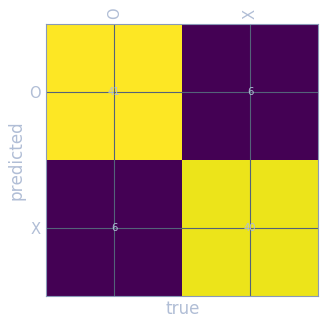

In [12]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

#### Feed-Forward (TF)

In [22]:
one_hot = np.array(train_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
train_label = one_hot_encoder.fit_transform(integer_encoder)

one_hot = np.array(test_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
test_label = one_hot_encoder.fit_transform(integer_encoder)

In [28]:
# important caveats here.. if we want to export it to .h5, then we have to use
# the keras.activations API instead of the tf.nn
# (possible solution is to export model JSON and weights separately)
model = keras.Sequential([
    keras.layers.Dense(10, activation=keras.activations.relu, input_shape=(13,)),
    keras.layers.Dense(2, activation=keras.activations.softmax)
]) 

In [29]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)

In [30]:
model.compile(optimizer=adm, 
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [31]:
history = model.fit( train_df.drop('label', axis=1), train_label, epochs=5000, batch_size=100, verbose=0)

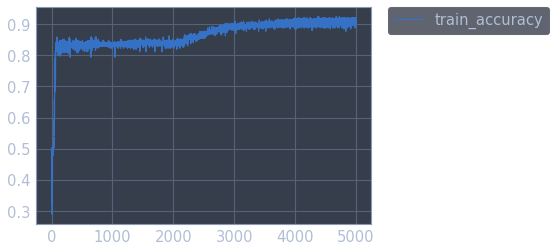

In [32]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [33]:
test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_label)

print('Test accuracy:', test_acc)

93/93 [==============================] - 0s 712us/sample - loss: 0.3027 - acc: 0.8387
Test accuracy: 0.83870965


#### Save Model for Use by TF-Serve

In [34]:
# Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
# to save model for TF-serving
import os
from pathlib import Path
from datetime import datetime as dt

save = True
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5']:  # TODO: JSON can be exported as well
        # save model as hdf5
        MODEL_DIR = f"models/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save can not handle existing repository
            !rm -r {export_path}

            tf.saved_model.simple_save(
                keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model.input},
                outputs={t.name:t for t in model.outputs})
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model.save(Path(export_path, 'saved_model.h5'), overwrite=False)

        print('\nSaved model:')
        !ls -l {export_path}

rm: cannot remove 'models/pb/1552056202': No such file or directory
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/pb/1552056202/saved_model.pb

Saved model:
total 368
-rw-r--r--. 1 macermak vpnusers 371339 Mar  8 15:43 saved_model.pb
drwxr-xr-x. 2 macermak vpnusers   4096 Mar  8 15:43 variables

Saved model:
total 16
-rw-r--r--. 1 macermak vpnusers 14416 Mar  8 15:43 saved_model.h5
